In [70]:
import torchvision
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # 内置的激活函数
# 复制数据
import os
import shutil

from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

#### python搬移数据

In [71]:
img_path = r'./第8章/dataset2' # 原始图片路径
base_path = r'./第8章/4weather' # 搬移路径
species = ['cloudy', 'rain', 'shine', 'sunrise'] # 4种分类

if os.path.isdir(base_path): # 判断是否存在文件夹
    # 存在删除文件夹
    shutil.rmtree(base_path) 
    # 创建子文件夹路径
    train_path = os.path.join(base_path , 'train') 
    test_path = os.path.join(base_path , 'test')   
    # 创建文件 
    os.mkdir(base_path)
    os.mkdir(train_path)
    os.mkdir(test_path)

for dirOf in ['train', 'test']:     
    for spec in species: # 取类别
        # 创建子文件夹路径
        specDir = os.path.join(base_path, dirOf, spec)
        # 创建文件 
        os.mkdir(specDir)

# enumerate在遍历序列的同时为每个元素生成一个索引下标
for i, img_name in enumerate(os.listdir(img_path), start=0):
    for spec in species: # 取类别
        if spec in img_name: # 判断哪种类别
            if i%5 == 0: # 1/5测试数据
                specFrom = os.path.join(img_path, img_name) # 源路径
                specTo = os.path.join(base_path, 'test', spec, img_name) # 新路径
            else:
                specFrom = os.path.join(img_path, img_name) # 源路径
                specTo = os.path.join(base_path, 'train', spec, img_name) # 新路径
            shutil.copyfile(specFrom, specTo) # 复制

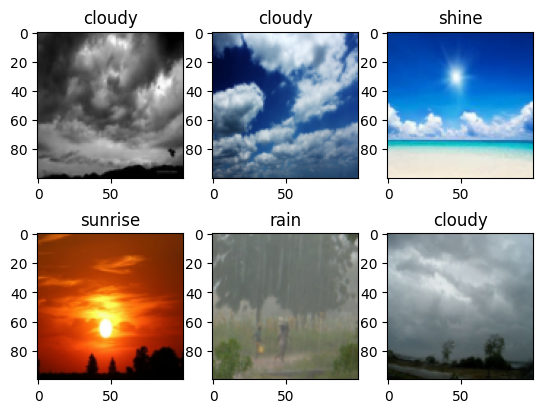

In [72]:
transform = transforms.Compose([
    transforms.Resize((100, 100)), # 统一大小
    transforms.ToTensor(), # 规范格式
])

# 从文件夹中创建dataset数据集
train_ds =  torchvision.datasets.ImageFolder(train_path,transform=transform)
test_ds =  torchvision.datasets.ImageFolder(test_path,transform=transform)

# 批次管理
batch_size = 16
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=batch_size)

imgs, labels = next(iter(train_dl))

# 交换字典中键值对的位置 {v: k for k, v in d.items()}
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}

for i,(img, label) in enumerate(zip(imgs[:6],labels[:6])):
    # 改变图片格式为(height, width, channel)
    img = img.permute(1,2,0)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(idx_to_class.get(label.item()))

#### 创建模型

In [73]:
# VGG架构
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn2d1 = nn.BatchNorm2d(16) # 批转换层
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.bn2d2 = nn.BatchNorm2d(32) # 批转换层
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn2d3 = nn.BatchNorm2d(64) # 批转换层
        # 池化层
        self.pool = nn.MaxPool2d(2)
        # 全连接层
        self.fc1 = nn.Linear(64*10*10,1024)
        self.bn1 = nn.BatchNorm1d(1024) # 批转换层
        self.fc2 = nn.Linear(1024,256)
        self.bn2 = nn.BatchNorm1d(256) # 批转换层
        self.fc3 = nn.Linear(256,4)
        # 抑制过拟合(训练好，预测差)
        self.drop = nn.Dropout(0.5)
        self.drop2d = nn.Dropout2d(0.5) 
    def forward(self,input):
        # 先BN层，再激活(原论文)
        x = self.pool(F.relu(self.bn2d1(self.conv1(input))))
        x = self.pool(F.relu(self.bn2d2(self.conv2(x))))
        x = self.pool(F.relu(self.bn2d3(self.conv3(x))))
        x = self.drop2d(x)
        # 暂停处理
        x = x.view(-1,64*10*10)
        x = self.drop(F.relu(self.bn1(self.fc1(x))))
        x = self.drop(F.relu(self.bn2(self.fc2(x))))
        logits = self.fc3(x)
        return logits

    
model = Model().to('cuda')
model(imgs.to('cuda')).shape

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=0.001) # lr 影响loss是否震荡

#### 训练函数

In [74]:
# 训练函数
def train(dl, model, loss_fn, optimizer):
    model.train() # 训练模式
    size = len(dl.dataset) # 总的个数    
    num_batches = len(dl) # 总批次数 = 总的个数//每批数
        
    train_loss, correct = 0, 0
        
    for x, y in dl:
        x, y = x.to('cuda'), y.to('cuda')
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # pred 第一维是每批数 
            correct += (pred.argmax(1) == y).float().sum().item()
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches
    
    return correct, train_loss

# 测试函数
def test(test_dl, model, loss_fn):
    model.eval() # 预测模式 
    size = len(test_dl.dataset)    
    num_batches = len(test_dl)
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to('cuda'), y.to('cuda')
            pred = model(x)         
            loss = loss_fn(pred, y)
            
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).float().sum().item()
        correct /= size
        test_loss /= num_batches
        return correct, test_loss
    
def fit(epochs,train_dl,test_dl,model, loss_fn, opt):
    # 列表记录每轮的数据
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
        
        # 追加到列表中
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
        
        # 打印模板
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
        
        print(template.format(epoch, epoch_train_loss, epoch_train_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss,train_acc,test_loss,test_acc

#### 开始训练

epoch: 0, train_Loss:0.79198, train_acc:68.9,test_Loss:0.47624, test_acc:80.4
epoch: 1, train_Loss:0.56206, train_acc:77.1,test_Loss:0.69490, test_acc:72.9
epoch: 2, train_Loss:0.62298, train_acc:76.1,test_Loss:0.37278, test_acc:86.2
epoch: 3, train_Loss:0.54725, train_acc:80.3,test_Loss:0.37816, test_acc:87.1
epoch: 4, train_Loss:0.52798, train_acc:81.4,test_Loss:0.34192, test_acc:89.3
epoch: 5, train_Loss:0.50879, train_acc:81.8,test_Loss:0.35685, test_acc:88.9
epoch: 6, train_Loss:0.46224, train_acc:83.4,test_Loss:0.29878, test_acc:88.9
epoch: 7, train_Loss:0.40138, train_acc:84.6,test_Loss:0.33510, test_acc:88.4
epoch: 8, train_Loss:0.42968, train_acc:84.0,test_Loss:0.37830, test_acc:85.8
epoch: 9, train_Loss:0.39654, train_acc:85.8,test_Loss:0.34733, test_acc:88.0
epoch:10, train_Loss:0.42189, train_acc:84.8,test_Loss:0.37237, test_acc:83.6
epoch:11, train_Loss:0.37969, train_acc:87.0,test_Loss:0.35473, test_acc:86.7
epoch:12, train_Loss:0.35625, train_acc:87.6,test_Loss:0.28722, 

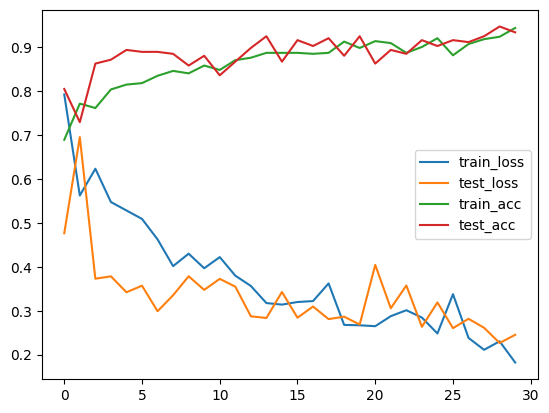

In [75]:
epochs = 30
(train_loss,
 train_acc,
 test_loss,
 test_acc) = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, loss_fn=loss_fn, opt=opt)

plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend() 